In [1]:
import pandas as pd
import csv
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from time import gmtime, strftime
from plotly.subplots import make_subplots
import plotly.offline as py
import json

# pd.set_option('display.max_rows', 500)
py.init_notebook_mode(connected=True)

datasetpath = 'https://raw.githubusercontent.com/fcampos300/covid19/master/dataset/'

# **DataFrame - Nível Brasil**

**Etapas de Preparação dos Dados:**

1.   Ordena o DF por estado, região e data: Necessário para pegar a diferença entre as linhas das colunas ***cases*** e ***deaths***;
2.   Adiciona a coluna calculada ***new_cases*** para novos casos: Busca a diferença entre a linha atual e a linha anterior da coluna ***cases***, onde os estados são iguais;
3.   Adiciona a coluna calculada ***new_deaths***  para novas mortes: Busca a diferença entre a linha atual e a linha anterior da coluna ***deaths***, onde os estados são iguais;
4.   Adiciona a coluna ***uf***: Adiciona a UF do estado de acordo com a variável mapeada UF;
5.   Converte a coluna data de *str* para *datetime*: Necessário para criar novas variáveis a partir da coluna;
6.   Cria novas colunas no DataFrame;
> * **Year**: Ano (year) indicado na coluna date.
> * **Month**: Mês (month) indicado na coluna date.
> * **Dayofweek**: Dia da semana (dayofweek) que pertence o dia indicado na coluna date.
> * **Weekofyear**: Número da semana (weekofyear) que pertence a data no ano.
> * **Weekend**: Coluna que indica se a data é um dia ou final de semana.
7.   Cria um novo DF com informações sobre a população nos estados brasileiros;
8.   Agrupa por região e estado e soma a coluna população;
5.   Junta os dois DFs;

In [2]:
df = pd.read_csv(datasetpath + 'brazil_covid19.csv', delimiter=",")
df = df.sort_values(['state', 'region', 'date'])

# Adiciona as colunas com casos/mortes novas por dia.
df['new_cases'] = np.where(df.state.eq(df.state.shift()), df.cases.diff(), 1)
df['new_deaths'] = np.where(df.state.eq(df.state.shift()), df.deaths.diff(), 1)

# Adiciona a coluna UF ao DataFrame.
UF = {'Acre':'AC',
      'Alagoas':'AL',
      'Amapá':'AP',
      'Amazonas':'AM',
      'Bahia':'BA',
      'Ceará':'CE',
      'Distrito Federal':'DF',
      'Espírito Santo':'ES',
      'Goiás':'GO',
      'Maranhão':'MA',
      'Mato Grosso':'MT',
      'Mato Grosso do Sul':'MS',
      'Minas Gerais': 'MG',
      'Pará':'PA',
      'Paraíba':'PB',
      'Paraná': 'PR',
      'Pernambuco':'PE',
      'Piauí':'PI',
      'Rio de Janeiro':'RJ',
      'Rio Grande do Norte':'RN',
      'Rio Grande do Sul':'RS',
      'Rondônia':'RO',
      'Roraima':'RR',
      'Santa Catarina':'SC',
      'São Paulo':'SP',
      'Sergipe':'SE',
      'Tocantins':'TO'}

df['uf'] = df.state.map(UF)

# Converte a coluna data de str para datetime.
df.date = pd.to_datetime(df.date, format="%Y-%m-%d")

# Cria novas colunas.
df["year"] = df.date.dt.year
df["month"] = df.date.dt.month
df["dayofweek"] = df.date.dt.dayofweek
df["weekofyear"] = df.date.dt.weekofyear
df["weekend"] = 0

df.loc[(df.dayofweek == 5) | (df.dayofweek == 6), 'weekend'] = 1

# Importa o dataset regiões/população.
df_pop = pd.read_csv(datasetpath + 'brazil_population_2019.csv', sep=",", error_bad_lines=False, index_col=False, warn_bad_lines=False)
df_pop = df_pop.groupby(['region', 'state']).sum()[['population']].reset_index()

df = pd.merge(df, df_pop, on=['region', 'state'])

df.tail()

,date,region,state,cases,deaths,new_cases,new_deaths,uf,year,month,dayofweek,weekofyear,weekend,population
1837,2020-05-16,Norte,Tocantins,1279,27,100.0,3.0,TO,2020,5,5,20,1,1110590
1838,2020-05-17,Norte,Tocantins,1382,31,103.0,4.0,TO,2020,5,6,20,1,1110590
1839,2020-05-18,Norte,Tocantins,1496,32,114.0,1.0,TO,2020,5,0,21,0,1110590
1840,2020-05-19,Norte,Tocantins,1646,38,150.0,6.0,TO,2020,5,1,21,0,1110590
1841,2020-05-20,Norte,Tocantins,1809,42,163.0,4.0,TO,2020,5,2,21,0,1110590


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1842 entries, 0 to 1841
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1842 non-null   datetime64[ns]
 1   region      1842 non-null   object        
 2   state       1842 non-null   object        
 3   cases       1842 non-null   int64         
 4   deaths      1842 non-null   int64         
 5   new_cases   1842 non-null   float64       
 6   new_deaths  1842 non-null   float64       
 7   uf          1842 non-null   object        
 8   year        1842 non-null   int64         
 9   month       1842 non-null   int64         
 10  dayofweek   1842 non-null   int64         
 11  weekofyear  1842 non-null   int64         
 12  weekend     1842 non-null   int64         
 13  population  1842 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(8), object(3)
memory usage: 215.9+ KB


Cria um DataFrame, a partir do DF original, agrupado por Data e adiciona as colunas ***mortality***, ***Recovered*** e ***Monitoring***.

In [4]:
df_copy = df.copy()

# Cria um DF agregado por Data;
df_br = df_copy.groupby(['date']).sum()[['cases',
                                         'deaths',
                                       ]].reset_index()

df_br['new_cases'] = df_br.cases.diff()
df_br['new_deaths'] = df_br.deaths.diff()

# Importa o DF com as colunas recovered e monitoring.
df_macro = pd.read_csv(datasetpath + 'brazil_covid19_macro.csv', sep=",", error_bad_lines=False, index_col=False, warn_bad_lines=False)
# Converte a coluna data de str para datetime.
df_macro.date = pd.to_datetime(df_macro.date, format="%Y-%m-%d")
# Deleta todas as colunas desnecessárias.
df_macro = df_macro.drop(['week', 'cases', 'deaths', 'country'], axis=1)

df_br = pd.merge(df_br, df_macro, on=['date'])

df_br['mortality'] = df_br.deaths / df_br.cases

df_br.tail()

,date,cases,deaths,new_cases,new_deaths,recovered,monitoring,mortality
80,2020-05-16,233142,15633,14919.0,816.0,89672,127837,0.067054
81,2020-05-17,241080,16118,7938.0,485.0,94122,130840,0.066857
82,2020-05-18,254220,16792,13140.0,674.0,100459,136969,0.066053
83,2020-05-19,271628,17971,17408.0,1179.0,106794,146863,0.066160
84,2020-05-20,291579,18859,19951.0,888.0,116683,156037,0.064679


# **Variáveis que serão usadas nas análises**

In [5]:
min_date = min(df.date)
min_date_en = f'{min_date.year}-{min_date.month:02d}-{min_date.day:02d}'
min_date_br = f'{min_date.day:02d}/{min_date.month:02d}/{min_date.year}'

max_date = max(df.date)
max_date_en = f'{max_date.year}-{max_date.month:02d}-{max_date.day:02d}'
max_date_br = f'{max_date.day:02d}/{max_date.month:02d}/{max_date.year}'

last_update = df_br.date.iloc[-1]
last_update_en = f'{last_update.year}-{last_update.month:02d}-{last_update.day:02d}'
last_update_br = f'{last_update.day:02d}/{last_update.month:02d}/{last_update.year}'

first_case = df.sort_values(['date']).query('cases > 0').date.iloc[0]
first_case_en = f'{first_case.year}-{first_case.month:02d}-{first_case.day:02d}'
first_case_br = f'{first_case.day:02d}/{first_case.month:02d}/{first_case.year}'

first_death = df.sort_values(['date']).query('deaths > 0').date.iloc[0]
first_death_en = f'{first_death.year}-{first_death.month:02d}-{first_death.day:02d}'
first_death_br = f'{first_death.day:02d}/{first_death.month:02d}/{first_death.year}'

confirmed_cases = df_br.cases.iloc[-1]
confirmed_deaths = df_br.deaths.iloc[-1]

new_cases_today = df_br.new_cases.iloc[-1]
new_deaths_today = df_br.new_deaths.iloc[-1]

mortality_rate = round((confirmed_deaths / confirmed_cases) * 100, 2)

In [6]:
print(f"Última Atualização: {last_update_br}\n")
print(f"Data do Primeiro Caso Confirmado: {first_case_br}")
print(f"Data da primeira Morte: {first_death_br}\n")
print(f"Casos Acumulados: {confirmed_cases}")
print(f"Mortes Acumuladas: {confirmed_deaths}")
print(f"Taxa de Mortalidade: {mortality_rate}%\n")
print(f"Novos Casos Hoje em {last_update_br}: {int(new_cases_today)}")
print(f"Novas Mortes Hoje em {last_update_br}: {int(new_deaths_today)}")

Última Atualização: 20/05/2020

Data do Primeiro Caso Confirmado: 26/02/2020
Data da primeira Morte: 17/03/2020

Casos Acumulados: 291579
Mortes Acumuladas: 18859
Taxa de Mortalidade: 6.47%

Novos Casos Hoje em 20/05/2020: 19951
Novas Mortes Hoje em 20/05/2020: 888


# **Verifica se existe colunas em branco no DF**

In [7]:
df.isnull().values.any()

False

In [8]:
df_br.isnull().values.any()

True

# **Verifica a correlação entra as colunas no DF**

In [9]:
# +1 = Forte correlação positiva.
#  0 = Não há correlação.
# -1 = Forte correlação negativa.
df.corr()

,cases,deaths,new_cases,new_deaths,year,month,dayofweek,weekofyear,weekend,population
cases,1.000000,0.982986,0.851109,0.837908,NaN,0.378447,-0.019439,0.404307,-0.008043,0.478728
deaths,0.982986,1.000000,0.834911,0.871950,NaN,0.319095,-0.015440,0.340734,-0.006575,0.483886
new_cases,0.851109,0.834911,1.000000,0.832539,NaN,0.362207,-0.028045,0.391215,-0.041366,0.409481
new_deaths,0.837908,0.871950,0.832539,1.000000,NaN,0.306569,-0.027432,0.329604,-0.040132,0.454890
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.378447,0.319095,0.362207,0.306569,NaN,1.000000,0.000616,0.922778,-0.000939,-0.092094
dayofweek,-0.019439,-0.015440,-0.028045,-0.027432,NaN,0.000616,1.000000,-0.134597,0.793813,0.000880
weekofyear,0.404307,0.340734,0.391215,0.329604,NaN,0.922778,-0.134597,1.000000,-0.095727,-0.112551
weekend,-0.008043,-0.006575,-0.041366,-0.040132,NaN,-0.000939,0.793813,-0.095727,1.000000,-0.002265
population,0.478728,0.483886,0.409481,0.454890,NaN,-0.092094,0.000880,-0.112551,-0.002265,1.000000


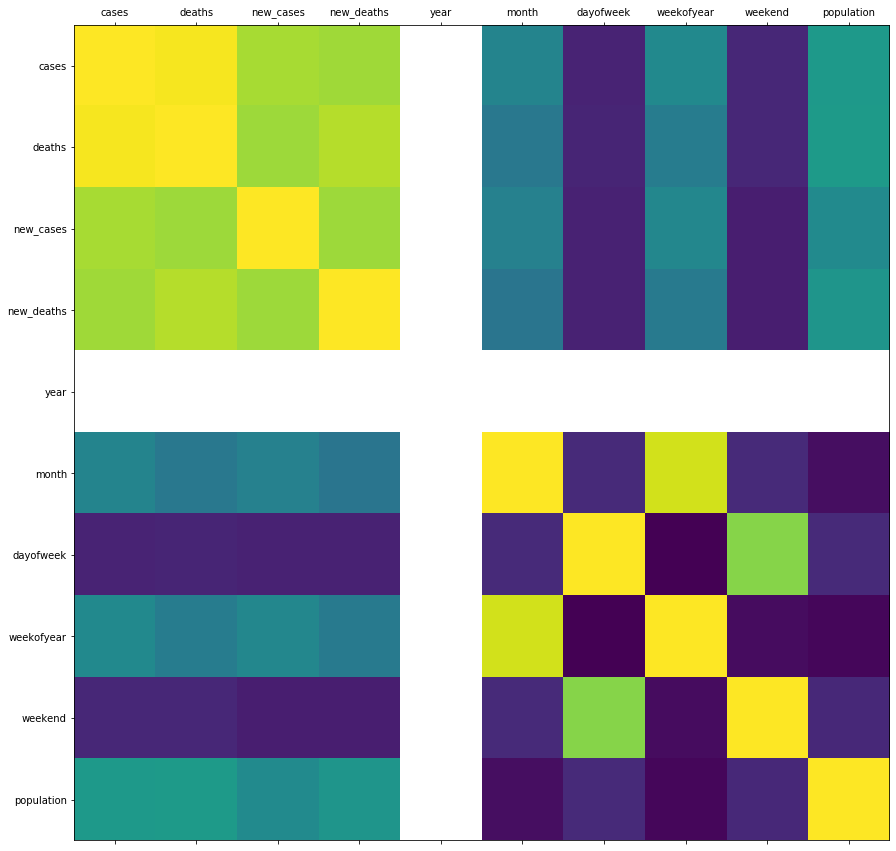

In [10]:
def plot_corr(df, size=15):
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr)
    
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(df)

# **Análises Nível Brasil**

**Preparação dos dados:**


>* Faz uma cópia do DF original;
>* Cria um DF agregado por **Data**;
>>* Adiciona a coluna calculada **Taxa de Mortalidade**.
>>* Adiciona a coluna calculada **Percentual de Casos**.
>>* Adiciona a coluna calculada **Percentual de Mortes**.
>* Cria um DF agregado por **Mês**;
>>* Adiciona a coluna calculada **Taxa de Mortalidade**.
>>* Adiciona a coluna calculada **Percentual de Casos**.
>>* Adiciona a coluna calculada **Percentual de Mortes**.
>>* Converte a coluna **mês** (int) para o nome do **mês** (str) correspondente.
>* Cria um DF agregado por **Dia da Semana**;
>>* Adiciona a coluna calculada **Taxa de Mortalidade**.
>>* Adiciona a coluna calculada **Percentual de Casos**.
>>* Adiciona a coluna calculada **Percentual de Mortes**.
>>* Converte a coluna **dia da semana** (int - 0 a 6) para o nome do **dia da semana** (str - Segunda a Domingo) correspondente.
>* Cria um DF agregado por **Semana do Ano**;
>>* Adiciona a coluna calculada **Taxa de Mortalidade**.
>>* Adiciona a coluna calculada **Percentual de Casos**.
>>* Adiciona a coluna calculada **Percentual de Mortes**.
>* Cria um DF agregado por **Final de Semana**;
>>* Adiciona a coluna calculada **Taxa de Mortalidade**.
>>* Adiciona a coluna calculada **Percentual de Casos**.
>>* Adiciona a coluna calculada **Percentual de Mortes**.
>>* Converte a coluna **final de semana** (int - 0 e 1) para **dia de semana**, caso o valor seja 0 e **final se semana**, caso o valor seja 1. *

**Gráficos**

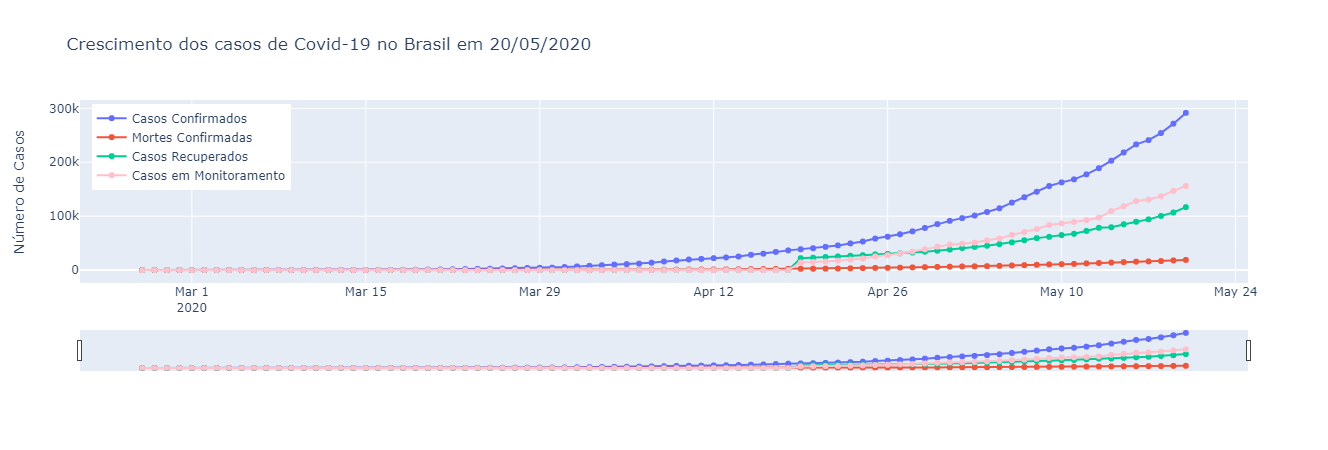

In [11]:
df_copy = df_br.copy()

date_x = df_copy['date']
confirmed_y = df_copy['cases']
mortes_y = df_copy['deaths']
recovered_y = df_copy['recovered']
monitoring_y = df_copy['monitoring']

fig = go.Figure()
fig.add_trace(go.Scatter(x=date_x, 
                         y=confirmed_y,
                         mode='lines+markers',
                         name='Casos Confirmados'))

fig.add_trace(go.Scatter(x=date_x, 
                         y=mortes_y,
                         mode='lines+markers',
                         name='Mortes Confirmadas'))

fig.add_trace(go.Scatter(x=date_x, 
                         y=recovered_y,
                         mode='lines+markers',
                         name='Casos Recuperados'))

fig.add_trace(go.Scatter(x=date_x, 
                         y=monitoring_y,
                         mode='lines+markers',
                         name='Casos em Monitoramento',
                         line=dict(color='Pink', width=2)))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title=f'Crescimento dos casos de Covid-19 no Brasil em {max_date_br}',
                  yaxis_title='Número de Casos', 
                  legend=dict(x=0.01,y=0.98))

fig.show()

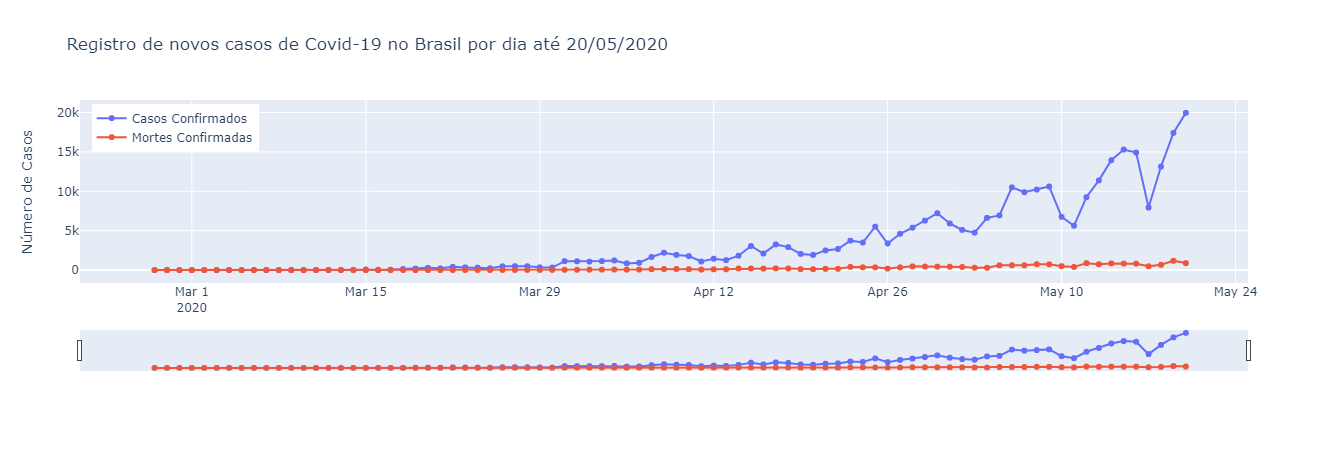

In [12]:
df_copy = df_br.copy()

date_x = df_copy['date']
confirmed_y = df_copy['new_cases']
mortes_y = df_copy['new_deaths']

# Criando as linhas
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_x, 
                         y=confirmed_y,
                         mode='lines+markers',
                         name='Casos Confirmados'))

fig.add_trace(go.Scatter(x=date_x, 
                         y=mortes_y,
                         mode='lines+markers',
                         name='Mortes Confirmadas'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title=f'Registro de novos casos de Covid-19 no Brasil por dia até {max_date_br}',
                  yaxis_title='Número de Casos',
                  legend=dict(x=0.01,y=0.98))

fig.show()

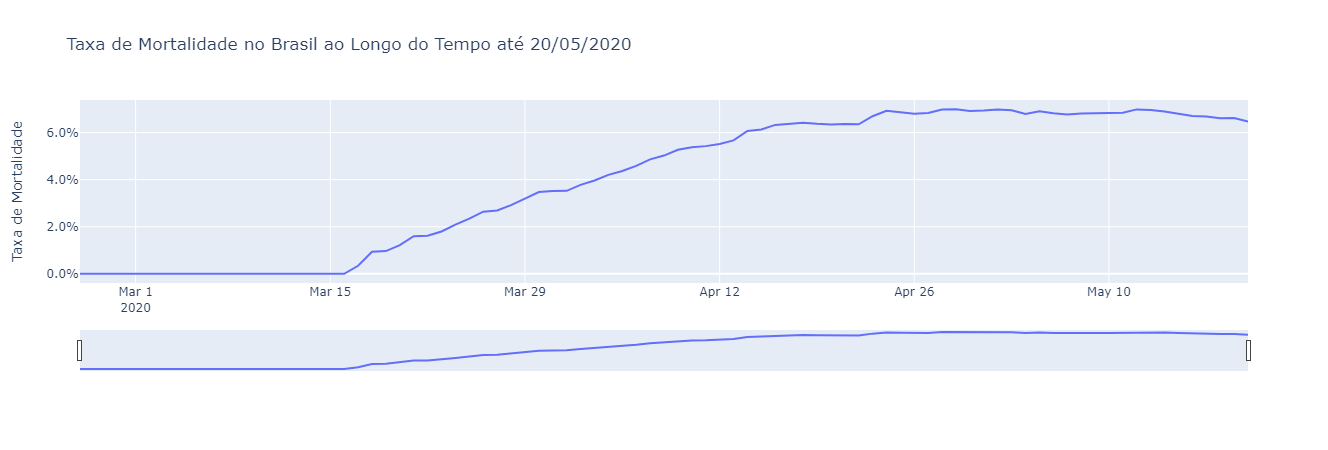

In [13]:
df_copy = df_br.copy()

date_x = df_copy['date']
rate_y = df_copy['mortality']

# Criando as linhas
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_x, y=rate_y,
                    mode='lines',
                    name='Mortalidade'))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title= f"Taxa de Mortalidade no Brasil ao Longo do Tempo até {max_date_br}",
                  yaxis_title='Taxa de Mortalidade', 
                  yaxis_tickformat = '.1%')

fig.show()

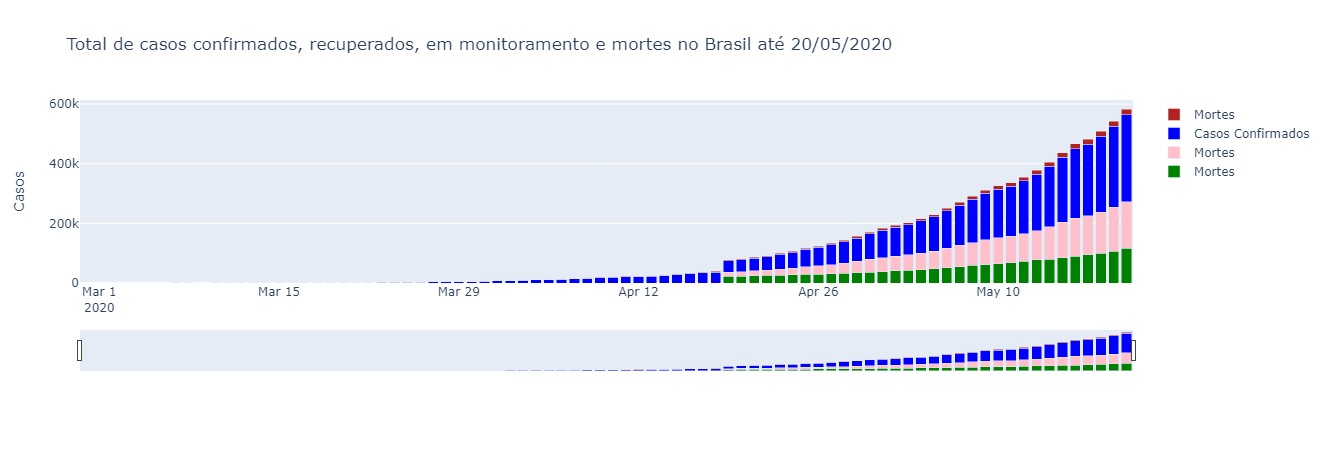

In [14]:
df_copy = df_br.copy()

df_copy = df_copy[(df_copy['new_cases'] > 0)]

colors = {'recovered':'green',
          'monitoring':'pink',
          'cases':'blue',
          'deaths':'firebrick'}

fig = go.Figure(data=[
    go.Bar(name='Mortes', 
           x=df_copy['date'], 
           y=df_copy['recovered'], 
           marker_color=colors['recovered']),
    go.Bar(name='Mortes', 
           x=df_copy['date'], 
           y=df_copy['monitoring'],
           marker_color=colors['monitoring']),
    go.Bar(name='Casos Confirmados', 
           x=df_copy['date'], 
           y=df_copy['cases'], 
           marker_color=colors['cases']),
    go.Bar(name='Mortes',
           x=df_copy['date'], 
           y=df_copy['deaths'], 
           marker_color=colors['deaths'])
])

fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(title_text='Casos')
fig.update_layout(title= f"Total de casos confirmados, recuperados, em monitoramento e mortes no Brasil até {max_date_br}",
                  barmode='stack')

fig.show()

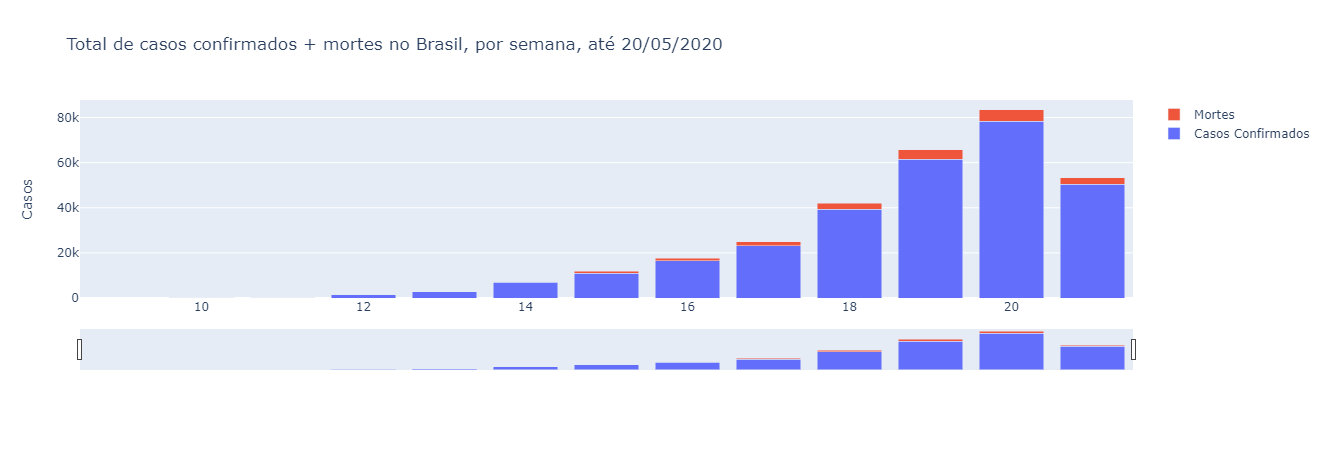

In [15]:
df_woy = df_br.copy()

df_woy["weekofyear"] = df_woy.date.dt.weekofyear
df_woy["new_cases"] = df_woy.new_cases.fillna(1)
df_woy["new_deaths"] = df_woy.new_deaths.fillna(0)
df_woy = df_woy.groupby(['weekofyear']).sum()[['new_cases',
                                               'new_deaths']].reset_index()

df_woy = df_woy[(df_woy['new_cases'] > 0)]

fig = go.Figure(data=[
    go.Bar(name='Casos Confirmados', x=df_woy['weekofyear'], y=df_woy['new_cases']),
    go.Bar(name='Mortes', x=df_woy['weekofyear'], y=df_woy['new_deaths'])
])

fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(title_text='Casos')
fig.update_layout(title= f"Total de casos confirmados + mortes no Brasil, por semana, até {max_date_br}",
                  barmode='stack')

fig.show()

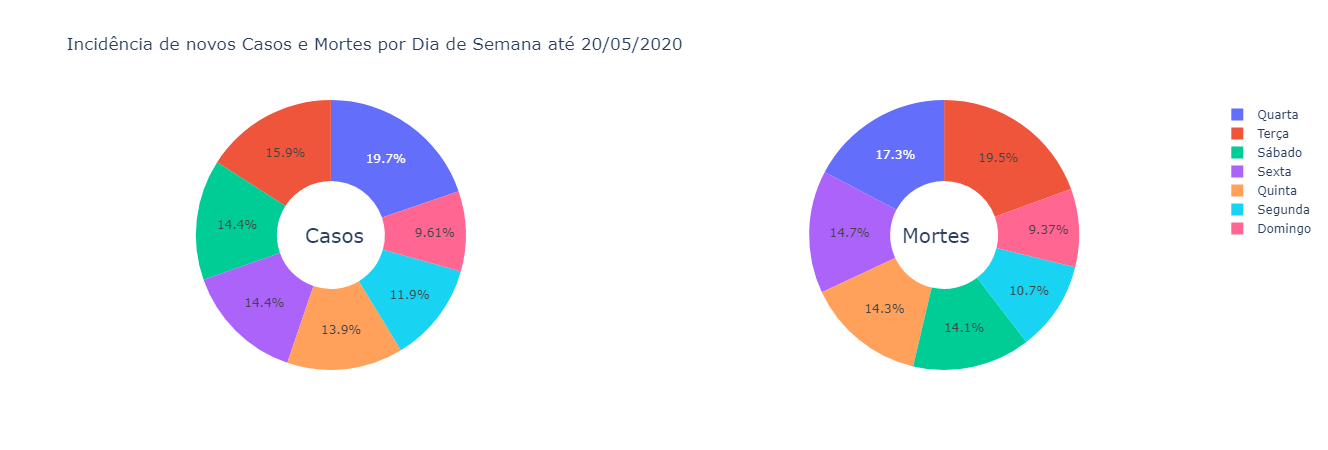

In [16]:
df_dow = df_br.copy()

df_dow["dayofweek"] = df_dow.date.dt.dayofweek
df_dow["new_cases"] = df_dow.new_cases.fillna(1)
df_dow["new_deaths"] = df_dow.new_deaths.fillna(0)

# Cria um DF agregado por Dia da Semana;
df_dow = df_dow.groupby(['dayofweek']).sum()[['new_cases',
                                              'new_deaths']].reset_index()

df_dow['dayofweekformated'] = df_dow.dayofweek.map({0: 'Segunda',
                                                    1: 'Terça',
                                                    2: 'Quarta',
                                                    3: 'Quinta',
                                                    4: 'Sexta',
                                                    5: 'Sábado',
                                                    6: 'Domingo',})

df_dow['mortality'] = df_dow.new_deaths / df_dow.new_cases
df_dow['mortality'].fillna(0, inplace=True)

labels = df_dow.dayofweekformated
values_casos = df_dow.new_cases
values_mortalidade = df_dow.new_deaths

fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels, 
                     values=values_casos, 
                     name="Casos Confirmados"),
              1, 1)

fig.add_trace(go.Pie(labels=labels, 
                     values=values_mortalidade, 
                     name="Mortes Confirmadas"),
              1, 2)

fig.update_traces(hole=.4,
                  hoverinfo="label+percent+name")

fig.update_layout(
    title_text=f"Incidência de novos Casos e Mortes por Dia de Semana até {max_date_br}",
  annotations=[dict(text='Casos', x=0.20, y=0.5, font_size=20, showarrow=False),
               dict(text='Mortes', x=0.80, y=0.5, font_size=20, showarrow=False)])
fig.show()

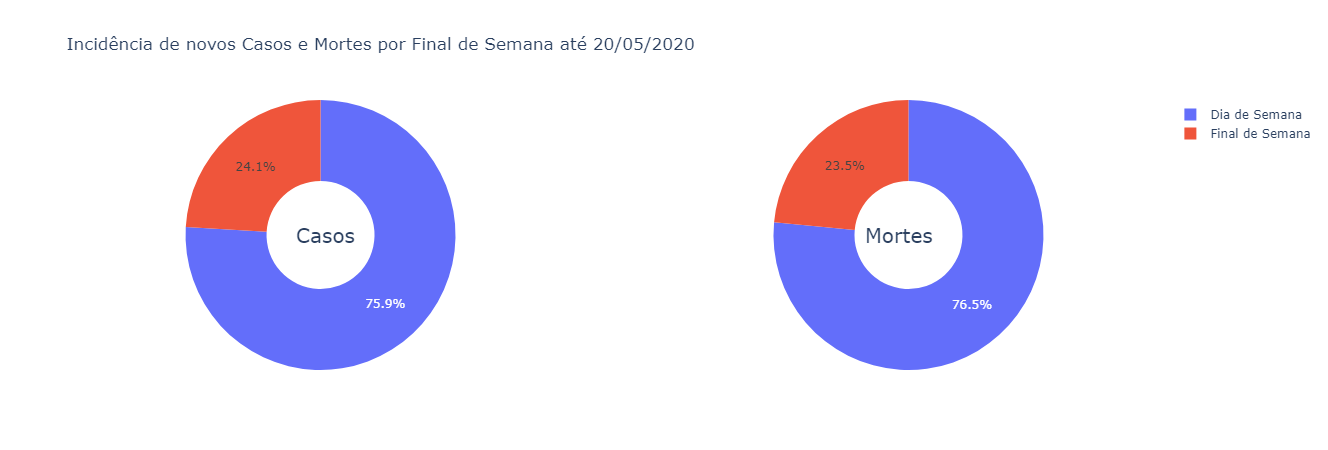

In [17]:
# Copia o DF original.
df_wen = df_br.copy()

# Adiciona a coluna dayofweek.
df_wen["dayofweek"] = df_wen.date.dt.dayofweek

# Preenche os valores nulos.
df_wen["new_cases"] = df_wen.new_cases.fillna(1)
df_wen["new_deaths"] = df_wen.new_deaths.fillna(0)

# Seta o final de semana
df_wen["weekend"] = 0
df_wen.loc[(df_wen.dayofweek == 5) | (df_wen.dayofweek == 6), 'weekend'] = 1

# Agrupa o novo DF.
df_wen = df_wen.groupby(['weekend']).sum()[['new_cases',
                                            'new_deaths']].reset_index()

# Renomeia os valores da coluna weekend.
df_wen["weekend"] = df_wen.weekend.replace({0: 'Dia de Semana',
                                            1: 'Final de Semana'})
# Monta o gráfico.
labels = df_wen.weekend
values_casos = df_wen.new_cases
values_mortalidade = df_wen.new_deaths

fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels, 
                     values=values_casos, 
                     name="Casos Confirmados"),
              1, 1)

fig.add_trace(go.Pie(labels=labels, 
                     values=values_mortalidade, 
                     name="Mortes Confirmadas"),
              1, 2)

fig.update_traces(hole=.4,
                  hoverinfo="label+percent+name")

fig.update_layout(
    title_text=f"Incidência de novos Casos e Mortes por Final de Semana até {max_date_br}",
  annotations=[dict(text='Casos', x=0.20, y=0.5, font_size=20, showarrow=False),
               dict(text='Mortes', x=0.80, y=0.5, font_size=20, showarrow=False)])
fig.show()

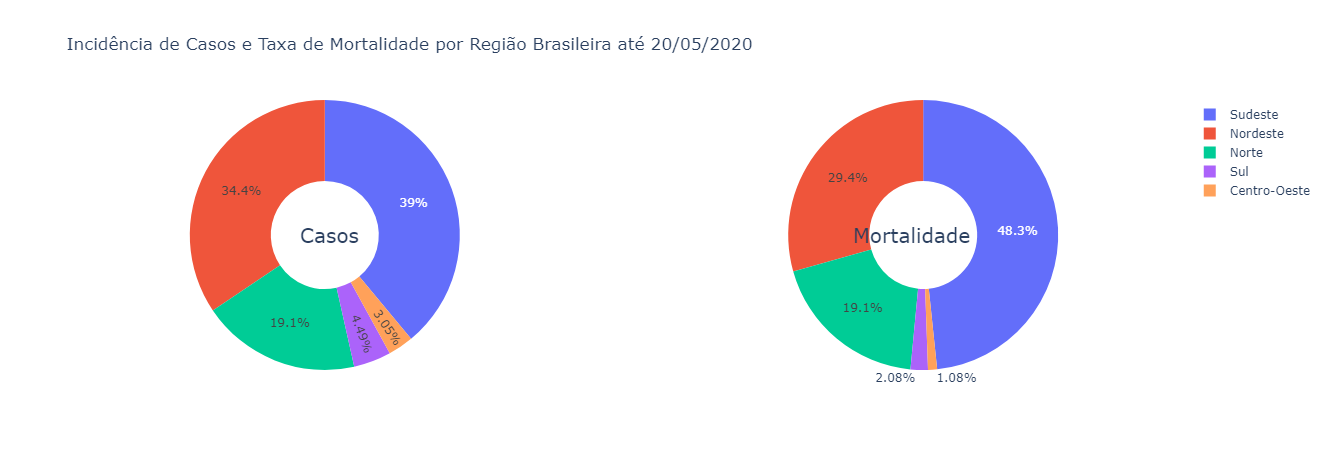

In [18]:
df_reg = df.copy()

# Cria um DF agregado por Data/Região;
df_reg = df_reg.groupby(['date', 'region']).sum()[['cases',
                                         'deaths'
                                       ]].reset_index()

df_reg = df_reg.sort_values(['region', 'date'])

df_reg['new_cases'] = np.where(df_reg.region.eq(df_reg.region.shift()), df_reg.cases.diff(), 1)
df_reg['new_deaths'] = np.where(df_reg.region.eq(df_reg.region.shift()), df_reg.deaths.diff(), 0)

df_reg = df_reg.groupby(['region']).sum()[['new_cases',
                                         'new_deaths'
                                       ]].reset_index()

# Adiciona novas colunas.
df_reg['mortality'] = df_reg.new_deaths  / df_reg.new_cases
df_reg['national_rate'] = df_reg.new_deaths.sum()  / df_reg.new_cases.sum()

labels = df_reg.region
values_casos = df_reg.new_cases
values_mortalidade = df_reg.new_deaths

fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[
                            {'type':'domain'}, 
                            {'type':'domain'}
                          ]])

fig.add_trace(go.Pie(labels=labels, 
                     values=values_casos,
                     name="Casos Confirmados"
                     ), 1, 1)

fig.add_trace(go.Pie(labels=labels, 
                     values=values_mortalidade, 
                     name="Taxa de Mortalidade"), 1, 2)

fig.update_traces(hole=.4, 
                  hoverinfo="label+percent+name"
                 )

fig.update_layout(
    title_text=f"Incidência de Casos e Taxa de Mortalidade por Região Brasileira até {max_date_br}",
 
    annotations=[dict(text='Casos', 
                      x=0.20, 
                      y=0.5, 
                      font_size=20, 
                      showarrow=False
                      ),
                 dict(text='Mortalidade', 
                      x=0.82,
                      y=0.5, 
                      font_size=20, 
                      showarrow=False
                      )
                ])

fig.show()

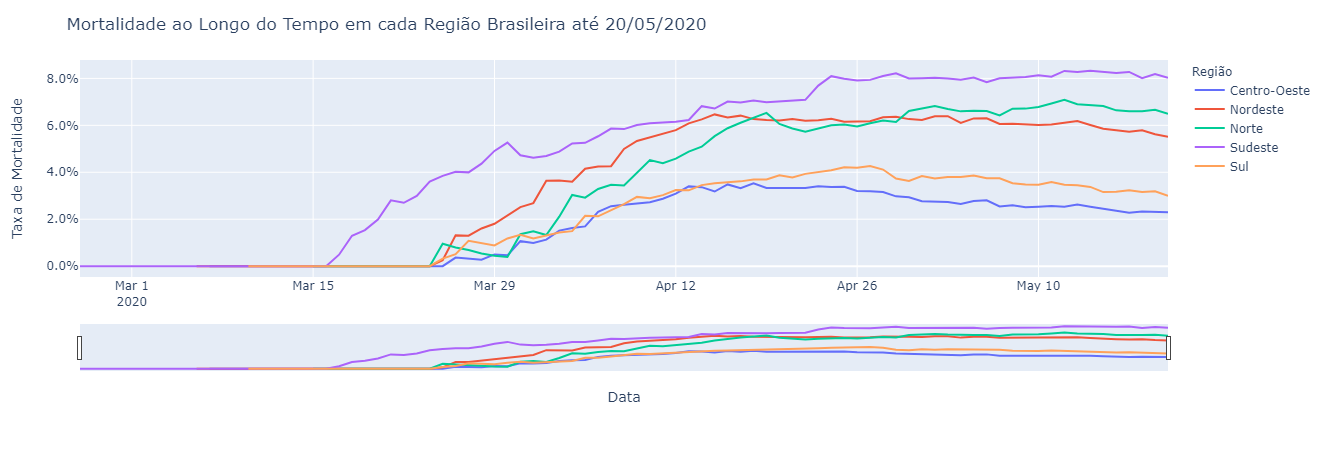

In [19]:
df_reg_dia = df.copy()

# Cria um DF agregado por Data/Região;
df_reg_dia = df_reg_dia.groupby(['date', 'region']).sum()[['cases',
                                                           'deaths', 
                                                           'population']].reset_index()

df_reg_dia = df_reg_dia.sort_values(['region', 'date'])

df_reg_dia['new_cases'] = np.where(df_reg_dia.region.eq(df_reg_dia.region.shift()), df_reg_dia.cases.diff(), 1)
df_reg_dia['new_deaths'] = np.where(df_reg_dia.region.eq(df_reg_dia.region.shift()), df_reg_dia.deaths.diff(), 0)
df_reg_dia['mortality'] = df_reg_dia.deaths / df_reg_dia.cases

fig = px.line(df_reg_dia, 
              x="date", 
              y="mortality", 
              color='region',
              labels={'region': 'Região',
                      'date': 'Data',
                      'mortality': 'Mortalidade',
                     }
             )

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title= f"Mortalidade ao Longo do Tempo em cada Região Brasileira até {max_date_br}",
                  yaxis_title = "Taxa de Mortalidade",
                  xaxis_title = "Data",
                  yaxis_tickformat = '.1%'
                 )

fig.show()

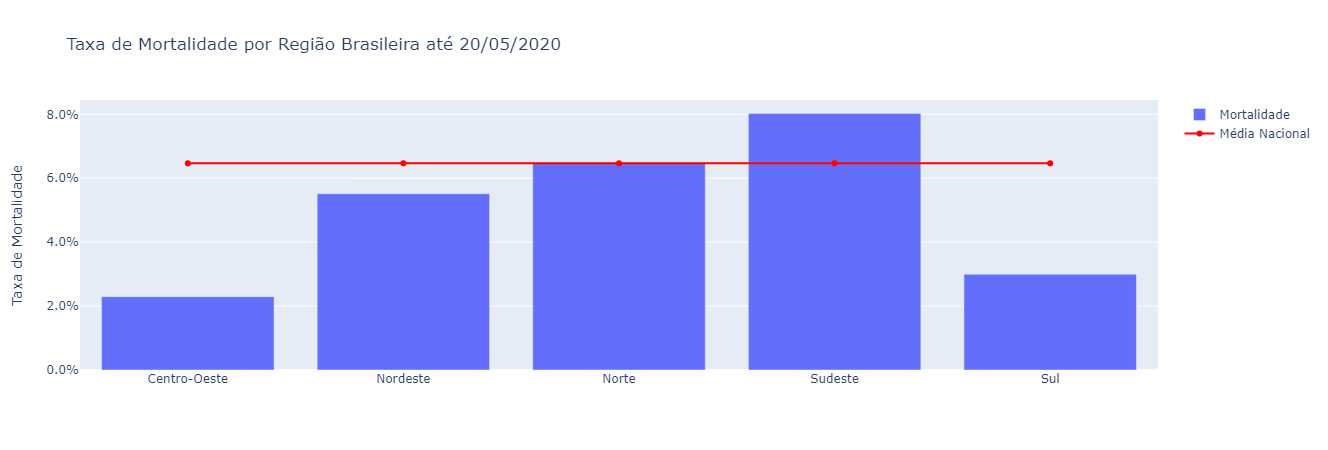

In [20]:
fig = go.Figure(data=[
    go.Bar(name='Mortalidade', x=df_reg['region'], y=df_reg['mortality']),
    go.Scatter(x=df_reg['region'], 
               y=df_reg['national_rate'],
               mode='lines+markers',
               line=dict(color='red'), 
               name='Média Nacional')
])

fig.update_yaxes(title_text='Taxa de Mortalidade')
fig.update_layout(title=f"Taxa de Mortalidade por Região Brasileira até {max_date_br}",
                  yaxis_tickformat = '.1%')

fig.show()

In [21]:
df_est = df.copy()

# Cria um DF agregado por Data/Região;
df_est = df_est.groupby(['date', 'state', 'uf']).sum()[['cases',
                                                        'deaths']].reset_index()

df_est = df_est.sort_values(['date', 'uf'])
df_est = df_est.tail(27)
df_est = df_est.set_index(df_est.uf)
df_est = df_est.drop(['date', 'uf'], axis=1)

# Adiciona novas colunas.
df_est['mortality'] = np.round((df_est.deaths / df_est.cases) * 100, 2)

df_est = df_est.style.background_gradient(cmap='Reds',subset=["cases"])\
                     .background_gradient(cmap='Reds',subset=["deaths"])\
                     .background_gradient(cmap='Reds',subset=["mortality"])\
                     .format("{:.2f}", subset=["mortality"])\

df_est

,state,cases,deaths,mortality
uf,,,,
AC,Acre,2817,76,2.70
AL,Alagoas,4437,251,5.66
AM,Amazonas,23704,1561,6.59
AP,Amapá,4549,142,3.12
BA,Bahia,11197,362,3.23
CE,Ceará,30560,1900,6.22
DF,Distrito Federal,5161,77,1.49
ES,Espírito Santo,8092,341,4.21
GO,Goiás,1978,78,3.94


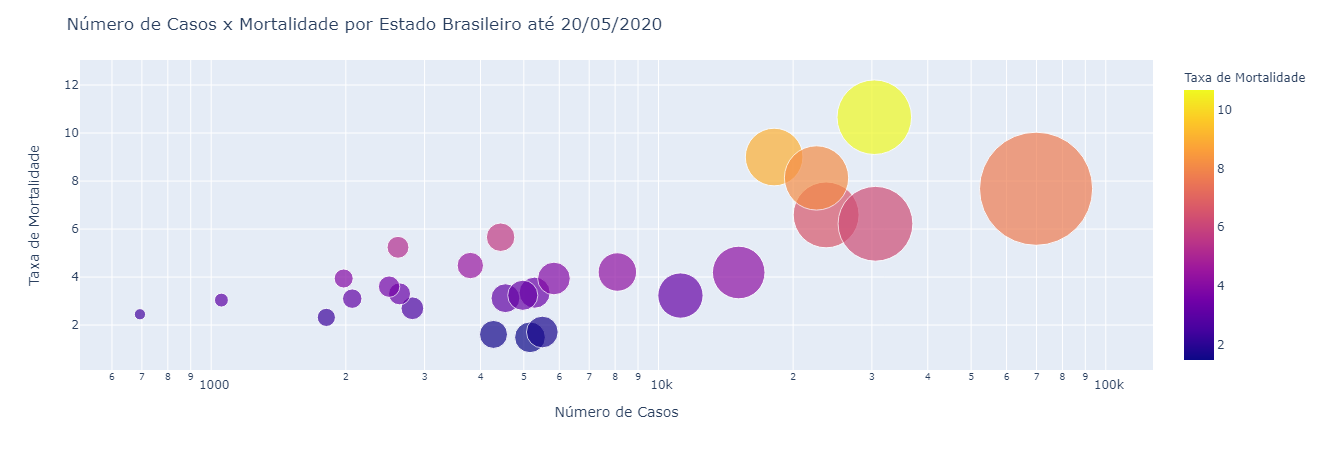

In [22]:
df_est = df.copy()

# Cria um DF agregado por Data/Região;
df_est = df_est.groupby(['date', 'state', 'uf']).sum()[['cases',
                                                        'deaths',
                                                        'population']].reset_index()

df_est = df_est.sort_values(['date', 'uf'])
df_est = df_est.tail(27)
df_est = df_est.set_index(df_est.uf)
df_est = df_est.drop(['date', 'uf'], axis=1)

# Adiciona novas colunas.
df_est['mortality'] = np.round((df_est.deaths / df_est.cases) * 100, 2)
df_est['national_rate'] = df_est.deaths.sum() / df_est.cases.sum()

fig = px.scatter(df_est, 
                 x="cases", 
                 y="mortality", 
                 size="cases", 
                 color=df_est.mortality,
                 hover_name=df_est.state, 
                 log_y=False, 
                 log_x=True, 
                 size_max=80,
                 labels={'cases': 'Casos Confirmados',
                         'mortality': 'Taxa de Mortalidade',
                        }
                )
fig.update_layout(title=f"Número de Casos x Mortalidade por Estado Brasileiro até {max_date_br}",
                  yaxis_title = "Taxa de Mortalidade",
                  xaxis_title = "Número de Casos",
                 )
fig.show()

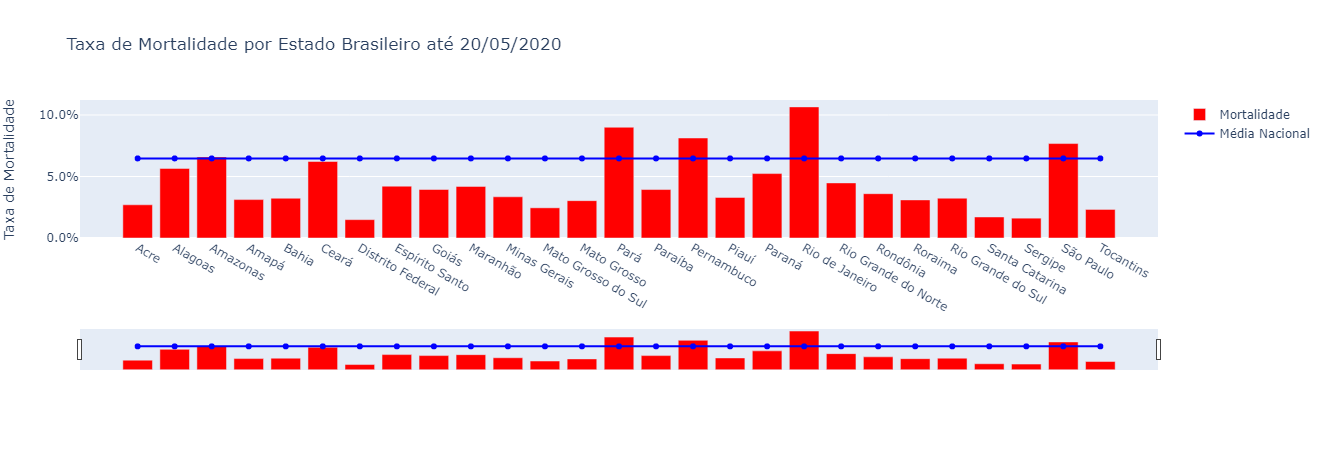

In [23]:
df_est['mortality_unf'] = df_est.deaths / df_est.cases

fig = go.Figure(data=[
    go.Bar(x=df_est['state'], 
           y=df_est['mortality_unf'],
           name='Mortalidade',
           marker_color='red'
          ),
    go.Scatter(x=df_est['state'], 
               y=df_est['national_rate'],
               mode='lines+markers',
               line=dict(color='blue'), 
               name='Média Nacional')
])

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(title=f"Taxa de Mortalidade por Estado Brasileiro até {max_date_br}",
                  yaxis_title='Taxa de Mortalidade',
                  yaxis_tickformat = '.1%')

fig.show()

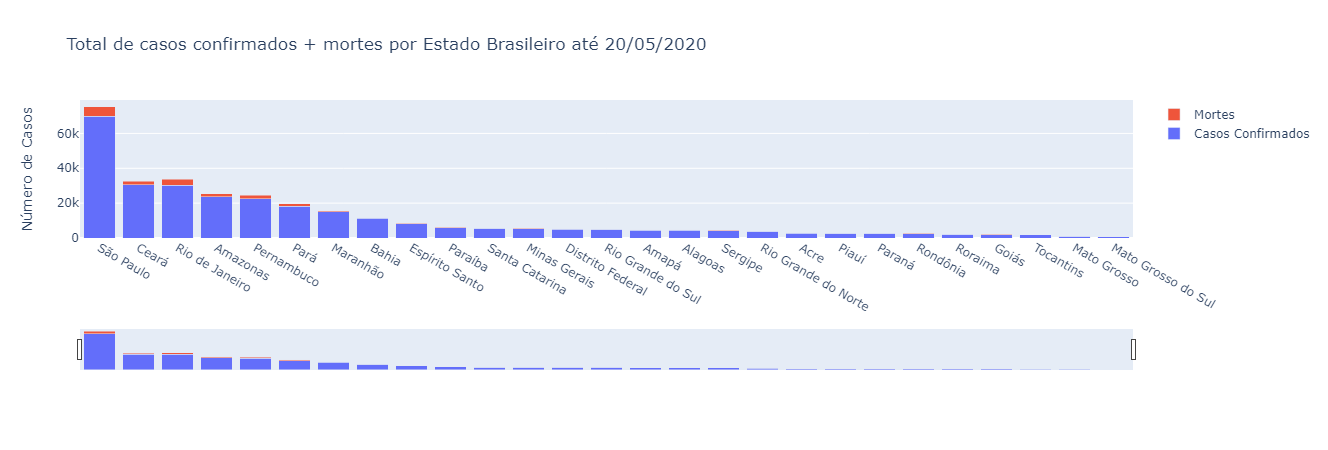

In [24]:
filt = df_est.copy()
filt = filt.sort_values(['cases'], ascending=False)

fig = go.Figure(data=[
    go.Bar(name='Casos Confirmados', x=filt['state'], y=filt['cases']),
    go.Bar(name='Mortes', x=filt['state'], y=filt['deaths'])
])

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title= f"Total de casos confirmados + mortes por Estado Brasileiro até {max_date_br}",
                  yaxis_title='Número de Casos',
                  barmode='stack')

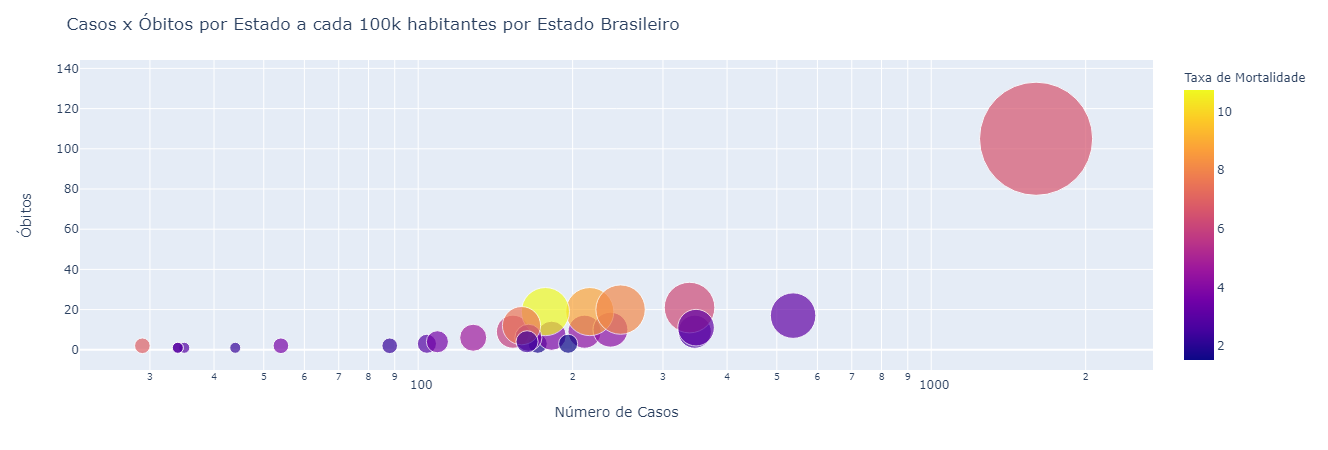

In [25]:
df_est2 = df_est.copy()
df_est2 = df_est2.drop(['mortality', 'mortality_unf'], axis=1)

df_est2['mortality'] = df_est2.deaths / df_est2.cases
df_est2['cases100k'] = round(df_est2.cases / (df_est2.population / 100000))
df_est2['deaths100k'] = round(df_est2.deaths / (df_est2.population / 100000))
df_est2['mortality100k'] = round((df_est2.deaths100k / df_est2.cases100k) * 100, 2)

fig = px.scatter(df_est2, 
                 x="cases100k", 
                 y="deaths100k", 
                 size="deaths100k", 
                 color=df_est2.mortality100k,
                 hover_name=df_est2.state, 
                 log_y=False, 
                 log_x=True, 
                 size_max=80,
                 labels={'cases100k': 'Casos',
                         'deaths100k': 'Óbitos',
                         'mortality100k': 'Taxa de Mortalidade',
                        }
                )
fig.update_layout(title= "Casos x Óbitos por Estado a cada 100k habitantes por Estado Brasileiro",
                  yaxis_title = "Óbitos",
                  xaxis_title = "Número de Casos",
                 )
fig.show()

> # **Mapas de Calor**

**Taxa de Mortalidade por Estado**

In [31]:
# Taxa de Mortalidade
filt = df_est2.copy()

filt.drop(['state',
           'cases',
           'deaths',
           'population',
           'national_rate',
           'cases100k',
           'deaths100k',
           'mortality100k'], axis=1, inplace=True)

filt['UF'] = filt.index
filt['Mortalidade'] = round(filt.mortality * 100, 2)

with open(datasetpath + 'Brasil.json', encoding='utf-8') as response:
    counties = json.load(response)

fig = px.choropleth_mapbox(filt, 
                           geojson=counties, 
                           locations=filt.UF, 
                           featureidkey="properties.UF",
                           color='Mortalidade',
                           range_color=(0, max(filt.Mortalidade)),
                           mapbox_style="carto-positron",
                           zoom=2.5, 
                           center = {"lat": -15.98, "lon": -49.86}, 
                           # opacity=0.9
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_coloraxes(colorbar_title="Taxa de Mortalidade",colorscale="reds")
fig.show()

OSError: [Errno 22] Invalid argument: 'https://raw.githubusercontent.com/fcampos300/covid19/master/dataset/Brasil.json'

**Total de Casos Confirmados por Estado**

In [ ]:
# Casos
filt = df_est2.copy()

filt.drop(['state',
           'deaths',
           'population',
           'national_rate',
           'cases100k',
           'deaths100k',
           'mortality',
           'mortality100k'], axis=1, inplace=True)

filt['UF'] = filt.index

fig = px.choropleth_mapbox(filt, 
                           geojson=counties, 
                           locations=filt.UF, 
                           featureidkey="properties.UF",
                           color='cases',
                           mapbox_style="carto-positron",
                           zoom=2.5, 
                           center = {"lat": -15.98, "lon": -49.86}, 
                           # opacity=0.9,
                           labels={'cases':'Casos Confirmados'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  title = 'teste'
                 )
fig.update_coloraxes(colorbar_title="Casos Confirmados", colorscale="blues")
fig.show()

**Total de Mortes por Estado**

In [ ]:
# Mortes
filt = df_est2.copy()

filt.drop(['state',
           'cases',
           'population',
           'national_rate',
           'cases100k',
           'deaths100k',
           'mortality',
           'mortality100k'], axis=1, inplace=True)

filt['UF'] = filt.index

fig = px.choropleth_mapbox(filt, 
                           geojson=counties, 
                           locations=filt.UF, 
                           featureidkey="properties.UF",
                           color='deaths',
                           mapbox_style="carto-positron",
                           zoom=2.5, 
                           center = {"lat": -15.98, "lon": -49.86}, 
                           # opacity=0.9,
                           labels={'deaths':'Mortes'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  title = 'teste'
                 )
fig.update_coloraxes(colorbar_title="Mortes", colorscale="reds")
fig.show()

**Total de Casos Confirmados por Estado a cada 100k habitantes**

In [ ]:
filt = df_est2.copy()

filt.drop(['state',
           'cases',
           'deaths',
           'population',
           'national_rate',
           'deaths100k',
           'mortality',
           'mortality100k'], axis=1, inplace=True)

filt['UF'] = filt.index

fig = px.choropleth_mapbox(filt, 
                           geojson=counties, 
                           locations=filt.UF, 
                           featureidkey="properties.UF",
                           color='cases100k',
                           mapbox_style="carto-positron",
                           zoom=2.5, 
                           center = {"lat": -15.98, "lon": -49.86}, 
                           # opacity=0.9,
                           labels={'cases100k':'Casos por 100k Habitantes'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  title = 'teste'
                 )
fig.update_coloraxes(colorbar_title="Casos por 100k", colorscale="blues")
fig.show()

**Total de Mortes por Estado a cada 100k Habitantes**

In [ ]:
filt = df_est2.copy()

filt.drop(['state',
           'cases',
           'deaths',
           'population',
           'national_rate',
           'cases100k',
           'mortality',
           'mortality100k'], axis=1, inplace=True)

filt['UF'] = filt.index

fig = px.choropleth_mapbox(filt, 
                           geojson=counties, 
                           locations=filt.UF, 
                           featureidkey="properties.UF",
                           color='deaths100k',
                           mapbox_style="carto-positron",
                           zoom=2.5, 
                           center = {"lat": -15.98, "lon": -49.86}, 
                           # opacity=0.9,
                           labels={'deaths100k':'Mortes por 100k Habitantes'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  title = 'teste'
                 )
fig.update_coloraxes(colorbar_title="Mortes por 100k", colorscale="reds")
fig.show()